In [11]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# python 3 version

##匯入資源
import urllib.request#python3:http://stackoverflow.com/questions/30261860/python-3-attributeerror-module-object-has-no-attribute-path-using-urll
import urllib.parse
import json
import gzip
import datetime #http://stackoverflow.com/questions/6288892/convert-datetime-format
import re
import calendar

print('交易日期')

##事先告知項目
print("”＊“ 代表非必填、“進口牛蒡“會拿掉處理")

##設定

#關於enddate
fmt = '%Y.%m.%d'
d = datetime.datetime.today()#http://stackoverflow.com/questions/4998629/python-split-string-with-multiple-delimiters
year = int(re.split('[.]', d.strftime(fmt))[0]) -1911
month = re.split('[.]', d.strftime(fmt))[1]
day = re.split('[.]', d.strftime(fmt))[2]
enddate = "%d.%s.%s" % (year, month, day)
yearslist = range(85, year+1)
#關於startdate
day = '01'
startdate = "%d.%s.%s" % (year, month, day)#第一次跑的時候，只跑到那個月的第一天，之後就一直跑那個月的組共資料

#關於時間年月日
months = {1:'01', 2:'02', 3:'03', 4:'04', 5:'05', 6:'06', 7:'07', 8:'08', 9:'09', 10:'10', 11:'11', 12:'12'}
monthsdays = {1:'31', 2:'28', 3:'31', 4:'30', 5:'31', 6:'30', 7:'31', 8:'31', 9:'30', 10:'31', 11:'30', 12:'31'}
monthsdays2 = monthsdays.copy()#http://stackoverflow.com/questions/2465921/how-to-copy-a-dictionary-and-only-edit-the-copy
monthsdays2[2] = '29'#monthsdays2 = {1:31, 2:29, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

#用一個function，每跑一次函數時間就會往前移動一個月
#關於startdate要比enddate少一個月，且要計算到上一個月的第一天
#因為會一直往前推一個月，可能會碰到閏年的2月，要小心有29天，另外要擔心如果要跨到上一年時的情況
def runmonthcycle(year, month, day):#https://www.codecademy.com/forum_questions/55cb254ee39efe13fd000087
    #先處理如果是一月的話
    if int(month) == 1:
        year -= 1
        month = months[12]
        day = monthsdays[12]
    #是閏年
    elif calendar.isleap(year+1911) == True:#http://stackoverflow.com/questions/11621740/how-to-determine-whether-a-year-is-a-leap-year-in-python
        day = monthsdays2[int(month)-1]
        month = months[int(month)-1]
    #不是閏年
    else:
        day = monthsdays[int(month)-1]
        month = months[int(month)-1]
    enddate = "%d.%s.%s" % (year, month, day)
    day = '01'
    startdate = "%d.%s.%s" % (year, month, day)
    #重新計算year, month, day
    #關於enddate
    return startdate, enddate, year, month, day

#關於產地
uriba = {1:'台北一', 2:'台北二', 3:'三重市', 4:'台中市', 5:'高雄市', 6:'鳳山市', 7:'桃園縣'}#6不是'鳳山區'
uribalist = range(7)
crop = '牛蒡'
top = '700'#raw_input('請輸入最大資料擷取數量: ')#一天的資料約有7~9站，預設1000筆資料
trandic = {'交易日期':'dat', '作物代號':'crs', '作物名稱':'cro', '市場名稱':'mar', '市場代號':'mas', '上價':'pru', '中價':'pro', '下價':'prd', '平均價':'prm', '交易量':'trv'}
market = ''

#要求輸入資料
def rundatainputcycle():
    marketinput = input('＊請擇一輸入： 1:台北一, 2:台北二, 3:三重市, 4:台中市, 5:高雄市, 6:鳳山區, 7:桃園縣 或是不填寫 > ')
    if len(str(marketinput)) == 0:
        market = ''
    elif len(str(marketinput)) ==1 and 1 <= int(marketinput) <= 7:
        market = uriba[int(uribalist[int(marketinput)-1]+1)]
    else:
        print('請重新輸入：1:台北一, 2:台北二, 3:三重市, 4:台中市, 5:高雄市, 6:鳳山區, 7:桃園縣 或是不填寫 > ')
        rundatainputcycle()
    return market
market = rundatainputcycle()

#匯入資料
def rundatacycle(market, startdate, enddate):
    url = 'http://m.coa.gov.tw/OpenData/FarmTransData.aspx?$top=' + top + '&$skip=0&' + urllib.parse.urlencode({'crop': crop}) + '&StartDate=' + startdate + '&EndDate=' + enddate
    if market != '':
        url += '&' + urllib.parse.urlencode({'Market': market})
    else:
        url = url
    data = urllib.request.urlopen(url).read().decode('utf-8')#http://stackoverflow.com/questions/28906859/module-has-no-attribute-urlencode
    result = json.loads(data)
    #改變資料結構
    for subdata in result:#subdata = {'下價': '32', '作物代號': 'SM1', '交易量': '620', '中價': '32', '市場名稱': '台北二', '平均價': '32', '作物名稱': '牛蒡', '上價': '32', '交易日期': '105.04.06', '市場代號': '104'}
        for ta, tb in trandic.items():#這個就沒有迴圈的效果
            subdata[tb] = subdata.pop(ta)
    return result
gouba_data = rundatacycle(market, startdate, enddate)

#開始按照月份把資料載下來，從今天所屬的這個月，一直自動存到資料的最開頭101.01.01
#先存這個月的資料出去

def savedata(market, startdate, enddate, year, month, day):
    #開始存資料
    global gouba_data
    with open(str(year) + month + '.json', 'w') as fout:#關於global和local變數的問題 http://stackoverflow.com/questions/10851906/python-3-unboundlocalerror-local-variable-referenced-before-assignment
        json.dump(gouba_data, fout)
        print(str(year) + month + 'json_saved')
    startdate, enddate, year, month, day= runmonthcycle(year, month, day)
    gouba_data = rundatacycle(market, startdate, enddate)
#     print(str(year), month, day)#test
    if year >= 101:
        savedata(market, startdate, enddate, year, month, day)
    return gouba_data, market, startdate, enddate, year, month, day
savedata(market, startdate, enddate, year, month, day)
        
        
"""
迴圈偵測，跑過的跳過，偵測檔案如果有存在，就跳過跑下一輪的迴圈
切成好幾個迴圈跑
等待時間，之後繼續跑迴圈

"""

交易日期
”＊“ 代表非必填、“進口牛蒡“會拿掉處理
＊請擇一輸入： 1:台北一, 2:台北二, 3:三重市, 4:台中市, 5:高雄市, 6:鳳山區, 7:桃園縣 或是不填寫 > 
{'prm': '29.4', 'crs': 'SM1', 'dat': '105.05.22', 'pru': '36.3', 'mas': '104', 'cro': '牛蒡', 'mar': '台北二', 'pro': '31', 'prd': '17.6', 'trv': '470'}
10505json_saved
105 04 01
10504json_saved
105 03 01
10503json_saved
105 02 01
10502json_saved
105 01 01
10501json_saved
104 12 01
10412json_saved
104 11 01
10411json_saved
104 10 01
10410json_saved
104 09 01
10409json_saved
104 08 01
10408json_saved
104 07 01
10407json_saved
104 06 01
10406json_saved
104 05 01
10405json_saved
104 04 01
10404json_saved
104 03 01
10403json_saved
104 02 01
10402json_saved
104 01 01
10401json_saved
103 12 01
10312json_saved
103 11 01
10311json_saved
103 10 01
10310json_saved
103 09 01
10309json_saved
103 08 01
10308json_saved
103 07 01
10307json_saved
103 06 01
10306json_saved
103 05 01
10305json_saved
103 04 01
10304json_saved
103 03 01
10303json_saved
103 02 01
10302json_saved
103 01 01
10301json_saved
102 12 01
10212j

'\n迴圈偵測，跑過的跳過，偵測檔案如果有存在，就跳過跑下一輪的迴圈\n切成好幾個迴圈跑\n等待時間，之後繼續跑迴圈\n\n'

In [16]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import csv
import json
import re
from itertools import islice

#設定資料
newdata = {}
title = ['crs', 'mas', 'dat', 'pru', 'pro', 'prd', 'prm', 'trv']
market = {'104':'台北二', '109':'台北一', '241':'三重市', '260':'宜蘭市', '420':'豐原鄉', '512':'永靖鄉', '514':'溪湖鎮', '540':'南投市', '648':'西螺鎮', '900':'屏東市', '400':'台中市', '800':'高雄市', '830':'鳳山市', '338':'桃園縣', '930':'台東市', '950':'花蓮市'}
months = {1:'01', 2:'02', 3:'03', 4:'04', 5:'05', 6:'06', 7:'07', 8:'08', 9:'09', 10:'10', 11:'11', 12:'12'}
for i in range(85, 101):
    for m in range(1, 13):
        newdata[str(i)+months[m]] = []

#每次載入一個新資料，只想跑一次那筆資料就把所有月份的資料都存下來

#轉存csv為json，從中擷取出資料
for y in range(85, 101):
    year = int(y)
    #判定資料的年份
    if int(y) < 100:
        name = '0' + str(y)
    else:
        name = str(y)
    dataurl = '101maeni/' + name + '.csv'
    #打開檔案
    with open(dataurl, 'r') as fin:
        AQdata = fin.read()
    #把資料換行的時候，當作是切成不同筆資料的分界點，成為多行資料形成的list，一行視為一筆資料
    rowslist = AQdata.split('\n')
    #把每個單行資料切成一個cell一個cell，每一行變成一個list，一個cell為一筆資料
    for rows in islice(rowslist, 1, None):#rows = crs,mas,dat,pru,pro,prd,prm,trv 等等，型態為str，而row = [crs,mas,dat,pru,pro,prd,prm,trv]，型態為list
        #http://stackoverflow.com/questions/10079216/skip-first-entry-in-for-loop-in-python
        #len(rowslist) 有五萬多筆
        row = rows.split(',')#要做切開的動作才會變成list
        row[0] = row[0].replace(' ', '')#有空白在當中，會影響辨識，所以要拿掉
        month = re.split('[.]', row[2])[1]
        data = {}
        #開始做資料轉存
        if row[0] == 'SM1' or row[0] == 'SM9':
            for i in range(8):
                data.update({title[i]:str(row[i])})
            if row[0] == "SM1":
                data['cro'] = '牛蒡'
            elif row[0] == "SM9":
                data['cro'] = '牛蒡-進口'
            for i in range(len(list(market))):#判別他屬於哪一個市場
                if str(row[1]) == list(market.keys())[i]:
                    data['mar'] = market[str(row[1])]
            newdata[str(year)+months[int(month)]].append(data)
    #開始存資料，上面的5萬多筆資料跑好後，按照存到哪一筆dictionary就存檔不同檔案
    for i in range(1, 13):#存入12個月份的資料
        with open(str(year) + months[i] + '.json', 'w') as save:
            json.dump(newdata[str(int(year))+months[i]], save)
            print(str(int(year))+months[i]+'json_saved')

# print(newdata)
# print(len(newdata))


8501json_saved
8502json_saved
8503json_saved
8504json_saved
8505json_saved
8506json_saved
8507json_saved
8508json_saved
8509json_saved
8510json_saved
8511json_saved
8512json_saved
8601json_saved
8602json_saved
8603json_saved
8604json_saved
8605json_saved
8606json_saved
8607json_saved
8608json_saved
8609json_saved
8610json_saved
8611json_saved
8612json_saved
8701json_saved
8702json_saved
8703json_saved
8704json_saved
8705json_saved
8706json_saved
8707json_saved
8708json_saved
8709json_saved
8710json_saved
8711json_saved
8712json_saved
8801json_saved
8802json_saved
8803json_saved
8804json_saved
8805json_saved
8806json_saved
8807json_saved
8808json_saved
8809json_saved
8810json_saved
8811json_saved
8812json_saved
8901json_saved
8902json_saved
8903json_saved
8904json_saved
8905json_saved
8906json_saved
8907json_saved
8908json_saved
8909json_saved
8910json_saved
8911json_saved
8912json_saved
9001json_saved
9002json_saved
9003json_saved
9004json_saved
9005json_saved
9006json_saved
9007json_s

In [143]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import json
with open('1005.json', 'r') as fout:
    udata = json.load(fout)
for i in range(len(udata)):
    print(udata[i])
    
# fin = open('ulist.json', 'r')
# udata = json.load(fin)
# fin.close()

FileNotFoundError: [Errno 2] No such file or directory: '1005.json'

In [144]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
#關於中文編碼的問題http://stackoverflow.com/questions/2688020/how-to-print-chinese-word-in-my-code-using-python
import json
import datetime
import os
import calendar
import re
import operator
from matplotlib.font_manager import FontProperties
if os.name == 'posix':#mac電腦的意思
    fpath = r"PMingLiU.ttf"
else:#windows的電腦用
    fpath = r"PMingLiU.ttf"
font = FontProperties(fname=fpath, size=12)

#關於時間年月日
months = {1:'01', 2:'02', 3:'03', 4:'04', 5:'05', 6:'06', 7:'07', 8:'08', 9:'09', 10:'10', 11:'11', 12:'12'}
monthsdays = {1:'31', 2:'28', 3:'31', 4:'30', 5:'31', 6:'30', 7:'31', 8:'31', 9:'30', 10:'31', 11:'30', 12:'31'}
monthsdays2 = monthsdays.copy()#http://stackoverflow.com/questions/2465921/how-to-copy-a-dictionary-and-only-edit-the-copy
monthsdays2[2] = '29'#monthsdays2 = {1:31, 2:29, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

fmt = '%Y.%m.%d'
d = datetime.datetime.today()#http://stackoverflow.com/questions/4998629/python-split-string-with-multiple-delimiters\
year = int(re.split('[.]', d.strftime(fmt))[0]) -1911
month = re.split('[.]', d.strftime(fmt))[1]
day = re.split('[.]', d.strftime(fmt))[2]
months = {1:'01', 2:'02', 3:'03', 4:'04', 5:'05', 6:'06', 7:'07', 8:'08', 9:'09', 10:'10', 11:'11', 12:'12'}

data_list = []
for i in range(85, year+1):
    if i == 105:
        for m in range(1, 6):
            data_list.append(str(i)+months[m]+'.json')
    elif i != 105:
        for m in range(1, 13):
            data_list.append(str(i)+months[m]+'.json')
# print(data_list)

#有沒有休市的問題
# suc = True
# for data in data_list:
#     with open(data, 'r') as fout:
#         udata = json.load(fout)
# #     print(len(udata))
#     for i in range(len(udata)):
#         if udata[i]['trv'] == '0':#有些農產品的上價或是下價是零，但是中價是有數字的，所以要看prm，不過發覺某些prm的值明明是0，但是還是有交易量，故從交易量下手
#             print(udata[i]['dat'], udata[i]['mar'])
#             suc = False
# if suc == True:
#     print('沒有休市問題')
    
#花蓮市場什麼時候開始不見？
# for data in data_list:
#     with open(data, 'r') as fout:
#         udata = json.load(fout)
#     for i in range(len(udata)):
#         if udata[i]['mas'] == '950':
#             print(udata[i]['dat'], udata[i]['mar'])
'''
104出現的資料維休市資料，所以從101.05.08之後就再也沒有出現過
'''

'\n104出現的資料維休市資料，所以從101.05.08之後就再也沒有出現過\n'

台北一 9331


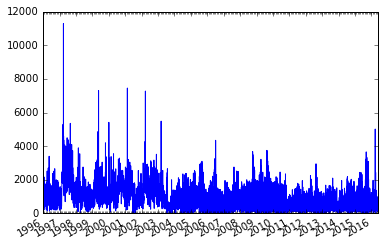

三重市 2471


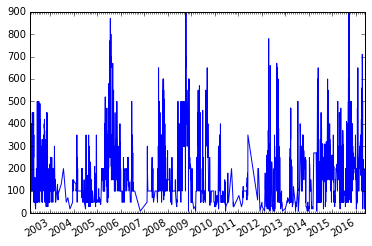

花蓮市 1483


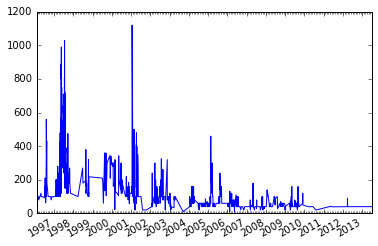

台北二 6968


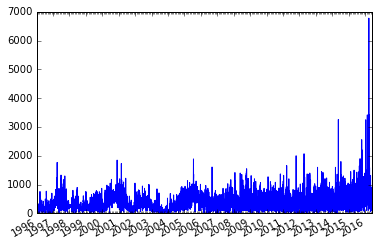

桃園縣 248


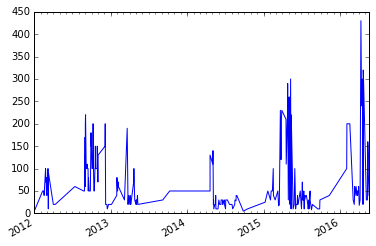

鳳山市 1851


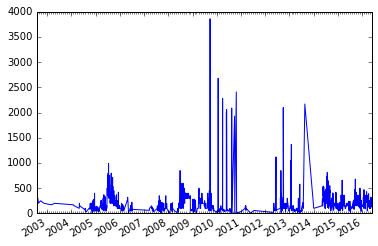

台中市 4165


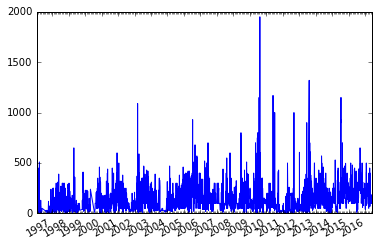

屏東市 2955


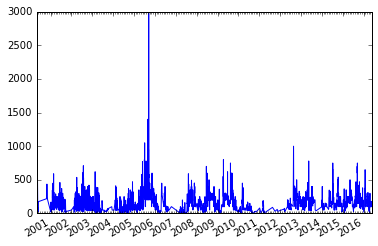

高雄市 7978


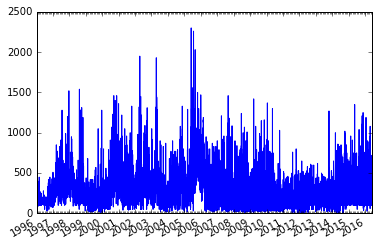

In [49]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

#每個批發市場的交易情形
#當中有進口牛蒡
#資料結構：市場：{'datetime':xx, 'pru':xx, 'pro':xx, 'prd':xx, 'prm':XX, 'trv':xx}
#製作：個別市場的不同天的「交易量」圖表、個別市場的不同天的「價格」圖表、所有市場的「總交易」量圖表、所有市場的「每天價格」圖表
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
market = {'104':'台北二', '109':'台北一', '241':'三重市', '260':'宜蘭市', '420':'豐原鄉', '512':'永靖鄉', '514':'溪湖鎮', '540':'南投市', '648':'西螺鎮', '900':'屏東市', '400':'台中市', '800':'高雄市', '830':'鳳山市', '338':'桃園縣', '930':'台東市', '950':'花蓮市'}
market_data = market.copy()
for num in market_data.keys():
    market_data[num] = []

#資料建立
for data in data_list:
    with open(data, 'r') as fout:
        udata = json.load(fout)
    for data in udata:
        if data['crs'] != 'rest':#不載入休市資料
            littletime = datetime.date(int(data['dat'].split('.')[0])+1911, int(data['dat'].split('.')[1]), int(data['dat'].split('.')[2]))
            market_data[data['mas']].append({'dat':littletime, 'pru':data['pru'], 'pro':data['pro'], 'prd':data['prd'], 'prm':data['prm'], 'trv':data['trv']})
for i in market_data.keys():#資料排序
    if len(market_data[i]) > 0:
        market_data[i].sort(key=operator.itemgetter('dat'))#http://stackoverflow.com/questions/2589479/how-do-i-sort-this-list-in-python-if-my-date-is-in-a-string
for i in market_data.keys():#轉變成圖表可以讀取的時間資訊
    if len(market_data[i]) > 0:
        for j in market_data[i]:
            j['dat']=md.date2num(j['dat'])
            
# print(market_data['338'])
##個別市場的不同天的「交易量」圖表
date1 = datetime.date(1996, 1, 1)
date2 = datetime.date(2016, 5, 31)
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')

##資料擷取
for i in market.keys():
    if len(market_data[i]) > 0:#不是空資料者才列印
        print(market[i], len(market_data[i]))#先印出名稱
        time_temp = []
        trv_temp = []
        for x in market_data[i]:
            time_temp.append(x['dat'])
            trv_temp.append(x['trv'])
        ##畫出線條
        fig, ax = plt.subplots()
        ax.plot_date(time_temp, trv_temp, '-')
        ##繪製圖表
        ax.xaxis.set_major_locator(years)#設定大年份
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.xaxis.set_minor_locator(months)
        ax.autoscale_view()
        ##顯示圖表
        fig.autofmt_xdate()
        plt.show()
        plt.close()

台北一 9331


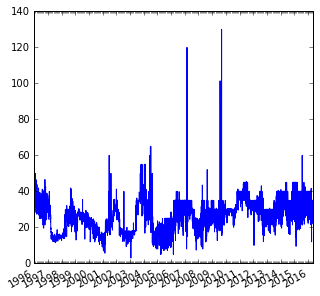

三重市 2471


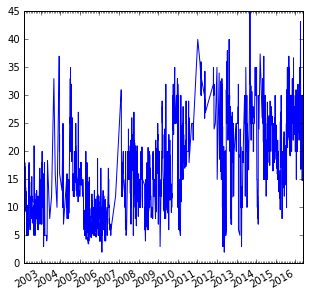

花蓮市 1483


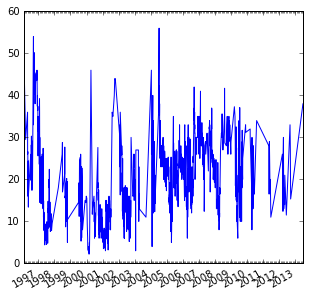

台北二 6968


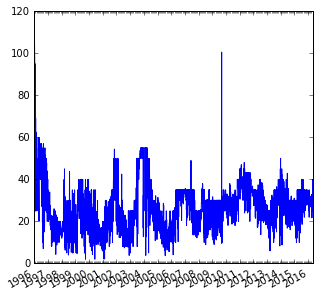

桃園縣 248


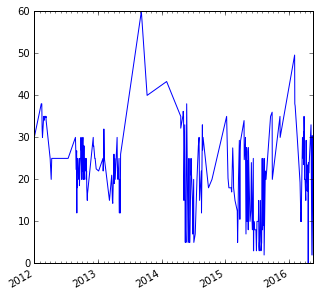

鳳山市 1851


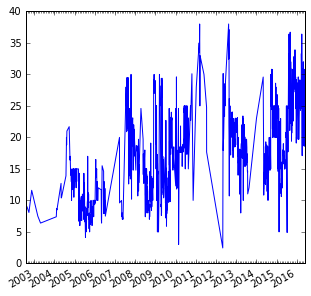

台中市 4165


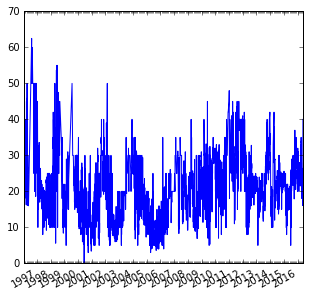

屏東市 2955


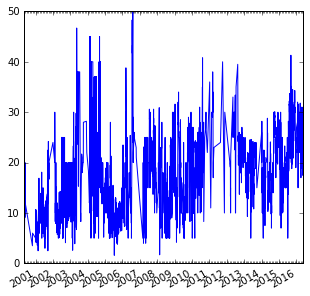

高雄市 7978


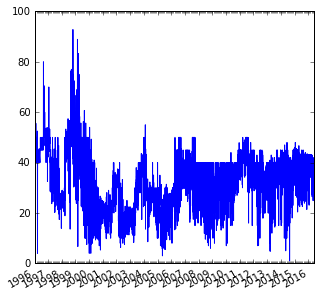

In [53]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

#個別市場的不同天的「價格」圖表
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
market = {'104':'台北二', '109':'台北一', '241':'三重市', '260':'宜蘭市', '420':'豐原鄉', '512':'永靖鄉', '514':'溪湖鎮', '540':'南投市', '648':'西螺鎮', '900':'屏東市', '400':'台中市', '800':'高雄市', '830':'鳳山市', '338':'桃園縣', '930':'台東市', '950':'花蓮市'}
market_data = market.copy()
for num in market_data.keys():
    market_data[num] = []

##資料建立
for data in data_list:
    with open(data, 'r') as fout:
        udata = json.load(fout)
    for data in udata:
        if data['crs'] != 'rest':#不載入休市資料
            littletime = datetime.date(int(data['dat'].split('.')[0])+1911, int(data['dat'].split('.')[1]), int(data['dat'].split('.')[2]))
            market_data[data['mas']].append({'dat':littletime, 'pru':data['pru'], 'pro':data['pro'], 'prd':data['prd'], 'prm':data['prm'], 'trv':data['trv']})
for i in market_data.keys():#資料排序
    if len(market_data[i]) > 0:
        market_data[i].sort(key=operator.itemgetter('dat'))
for i in market_data.keys():#轉變成圖表可以讀取的時間資訊
    if len(market_data[i]) > 0:
        for j in market_data[i]:
            j['dat']=md.date2num(j['dat'])
# for xx in market_data.keys():
#     print(len(market_data[xx]))
# print(market_data['338'])
##個別市場的不同天的「交易量」圖表
date1 = datetime.date(1996, 1, 1)
date2 = datetime.date(2016, 5, 31)
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')

##資料擷取
for i in market.keys():
    if len(market_data[i]) > 0:#不是空資料者才列印
        print(market[i], len(market_data[i]))#先印出名稱
        time_temp = []
        prm_temp = []
        for x in market_data[i]:
            time_temp.append(x['dat'])
            prm_temp.append(x['prm'])
        ##畫出線條
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot_date(time_temp, prm_temp, '-')
        ##繪製圖表
        ax.xaxis.set_major_locator(years)#設定大年份
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.xaxis.set_minor_locator(months)
        ax.autoscale_view()
        ##顯示圖表
        fig.autofmt_xdate()
        plt.show()
        plt.close()

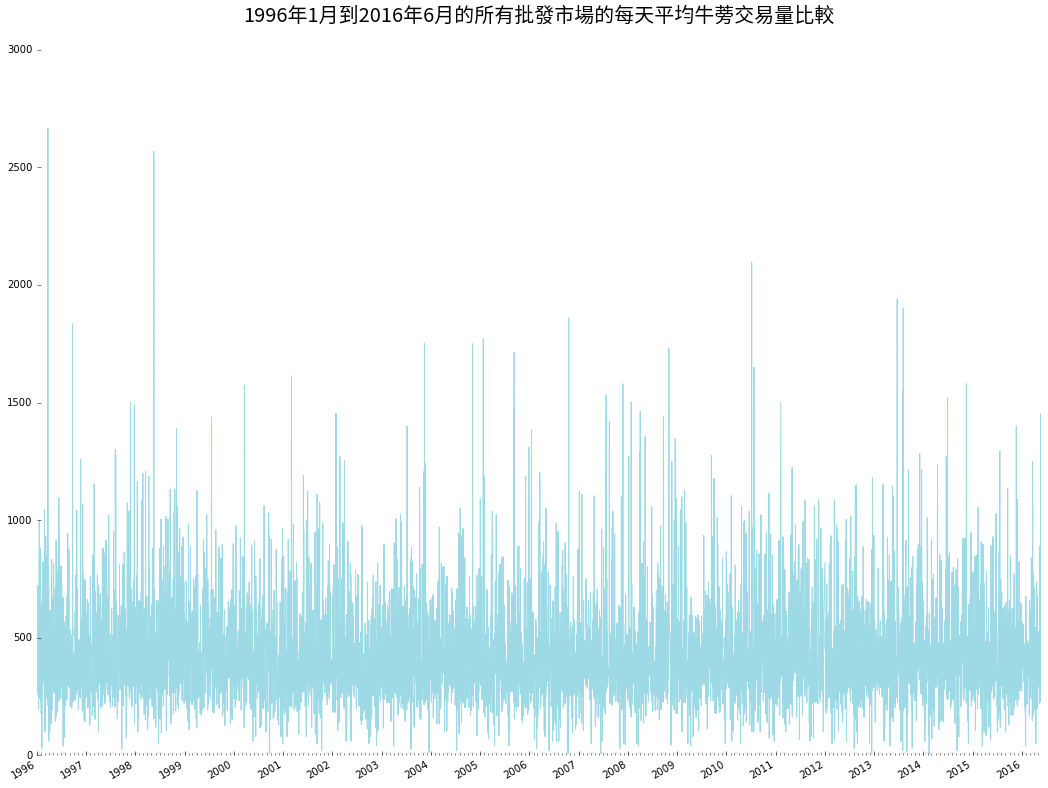

In [59]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

#所有市場的「平均交易」量圖表
%matplotlib inline
import numpy
import collections
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
class SortedDisplayDict(dict):#http://stackoverflow.com/questions/9001509/how-can-i-sort-a-dictionary-by-key
   def __str__(self):
       return "{" + ", ".join("%r: %r" % (key, self[key]) for key in sorted(self)) + "}"
market = {'104':'台北二', '109':'台北一', '241':'三重市', '260':'宜蘭市', '420':'豐原鄉', '512':'永靖鄉', '514':'溪湖鎮', '540':'南投市', '648':'西螺鎮', '900':'屏東市', '400':'台中市', '800':'高雄市', '830':'鳳山市', '338':'桃園縣', '930':'台東市', '950':'花蓮市'}
market_data = market.copy()
for num in market_data.keys():
    market_data[num] = []

##資料建立
for data in data_list:
    with open(data, 'r') as fout:
        udata = json.load(fout)
    for data in udata:
        if data['crs'] != 'rest':#不載入休市資料
            littletime = datetime.date(int(data['dat'].split('.')[0])+1911, int(data['dat'].split('.')[1]), int(data['dat'].split('.')[2]))
            market_data[data['mas']].append({'dat':littletime, 'pru':data['pru'], 'pro':data['pro'], 'prd':data['prd'], 'prm':data['prm'], 'trv':data['trv']})
for i in market_data.keys():#資料排序
    if len(market_data[i]) > 0:
        market_data[i].sort(key=operator.itemgetter('dat'))

# for xx in market_data.keys():
#     print(len(market_data[xx]))
# print(market_data['338'])
##個別市場的不同天的「交易量」圖表
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')

##資料擷取
dat_list = []
dat_dic = {}
for i in market.keys():#先處理日期的問題
    if len(market_data[i]) > 0:#不是空資料者才列印
        for data in market_data[i]:
            if data['dat'] not in dat_list:
                dat_list.append(data['dat'])
                dat_dic[data['dat']] = []
dat_dic = SortedDisplayDict(dat_dic)#http://stackoverflow.com/questions/9001509/how-can-i-sort-a-dictionary-by-key
for i in market.keys():
    if len(market_data[i]) > 0:
        for data in market_data[i]:
            dat_dic[data['dat']].append(float(data['trv']))
# print(dat_dic)
time_temp = []
trv_temp = []
for i, j in dat_dic.items():
    time_temp.append(md.date2num(i))
    trv_temp.append(float(numpy.mean(j)))
time_temp.sort()
# print(prm_temp)
##畫出線條
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
ax.plot_date(time_temp, trv_temp, '-', color = '#9edae5')
plt.title('1996年1月到2016年6月的所有批發市場的每天平均牛蒡交易量比較\n', fontproperties=FontProperties(fname=fpath, size=20), ha='center')#繪製圖片的標題#http://matplotlib.org/examples/pylab_examples/fonts_demo.html
#繪製格線方便使用者看
for y in range(10, maxdata, 1000):
    plt.plot(time_temp, [y] * len(time_temp), '--', lw=0.5, color='black', alpha=0.3)
#移除一些不必要的東西
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
##繪製圖表
ax.xaxis.set_major_locator(years)#設定大年份
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()
##顯示圖表
fig.autofmt_xdate()
plt.show()
plt.close()


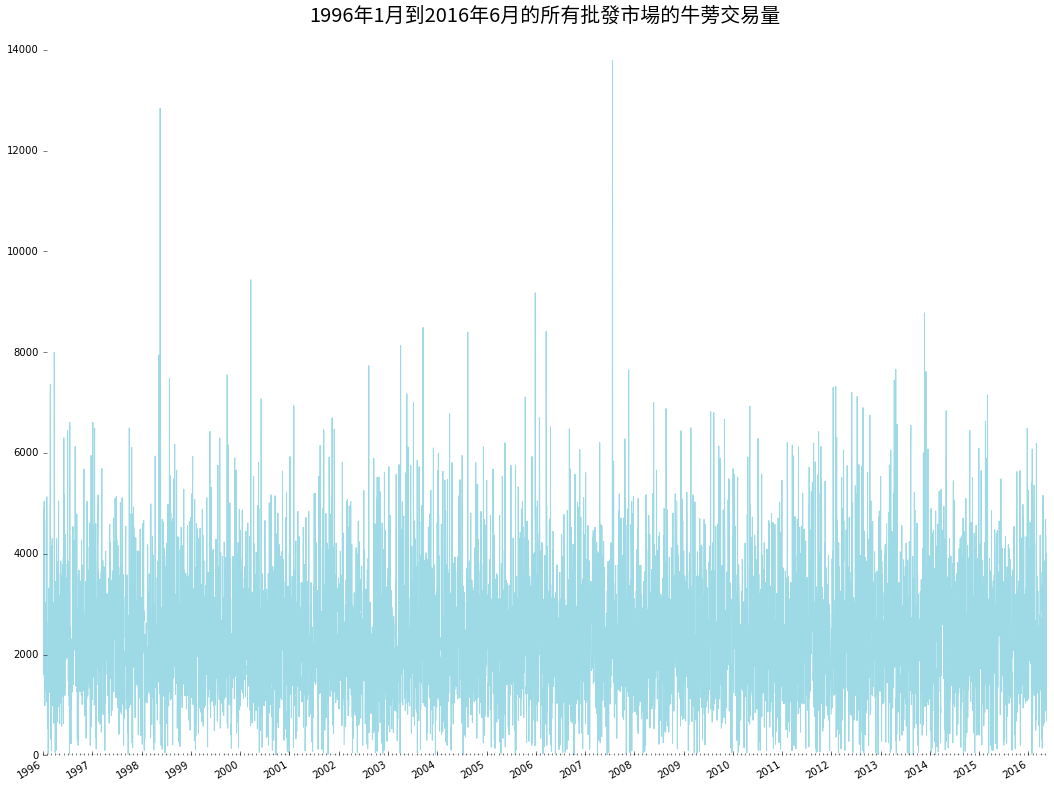

In [60]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

#所有市場的「總交易」量圖表
%matplotlib inline
import numpy
import collections
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
class SortedDisplayDict(dict):#http://stackoverflow.com/questions/9001509/how-can-i-sort-a-dictionary-by-key
   def __str__(self):
       return "{" + ", ".join("%r: %r" % (key, self[key]) for key in sorted(self)) + "}"
market = {'104':'台北二', '109':'台北一', '241':'三重市', '260':'宜蘭市', '420':'豐原鄉', '512':'永靖鄉', '514':'溪湖鎮', '540':'南投市', '648':'西螺鎮', '900':'屏東市', '400':'台中市', '800':'高雄市', '830':'鳳山市', '338':'桃園縣', '930':'台東市', '950':'花蓮市'}
market_data = market.copy()
for num in market_data.keys():
    market_data[num] = []

##資料建立
for data in data_list:
    with open(data, 'r') as fout:
        udata = json.load(fout)
    for data in udata:
        if data['crs'] != 'rest':#不載入休市資料
            littletime = datetime.date(int(data['dat'].split('.')[0])+1911, int(data['dat'].split('.')[1]), int(data['dat'].split('.')[2]))
            market_data[data['mas']].append({'dat':littletime, 'pru':data['pru'], 'pro':data['pro'], 'prd':data['prd'], 'prm':data['prm'], 'trv':data['trv']})
for i in market_data.keys():#資料排序
    if len(market_data[i]) > 0:
        market_data[i].sort(key=operator.itemgetter('dat'))

# for xx in market_data.keys():
#     print(len(market_data[xx]))
# print(market_data['338'])
##個別市場的不同天的「交易量」圖表
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')

##資料擷取
dat_list = []
dat_dic = {}
for i in market.keys():#先處理日期的問題
    if len(market_data[i]) > 0:#不是空資料者才列印
        for data in market_data[i]:
            if data['dat'] not in dat_list:
                dat_list.append(data['dat'])
                dat_dic[data['dat']] = []
dat_dic = SortedDisplayDict(dat_dic)#http://stackoverflow.com/questions/9001509/how-can-i-sort-a-dictionary-by-key
for i in market.keys():
    if len(market_data[i]) > 0:
        for data in market_data[i]:
            dat_dic[data['dat']].append(float(data['trv']))
# print(dat_dic)
time_temp = []
trv_temp = []
for i, j in dat_dic.items():
    time_temp.append(md.date2num(i))
    trv_temp.append(float(numpy.sum(j)))
time_temp.sort()
# print(prm_temp)
##畫出線條
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
ax.plot_date(time_temp, trv_temp, '-', color = '#9edae5')
plt.title('1996年1月到2016年6月的所有批發市場的牛蒡交易量\n', fontproperties=FontProperties(fname=fpath, size=20), ha='center')#繪製圖片的標題#http://matplotlib.org/examples/pylab_examples/fonts_demo.html
#繪製格線方便使用者看
for y in range(10, maxdata, 1000):
    plt.plot(time_temp, [y] * len(time_temp), '--', lw=0.5, color='black', alpha=0.3)
#移除一些不必要的東西
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
##繪製圖表
ax.xaxis.set_major_locator(years)#設定大年份
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()
##顯示圖表
fig.autofmt_xdate()
plt.show()
plt.close()


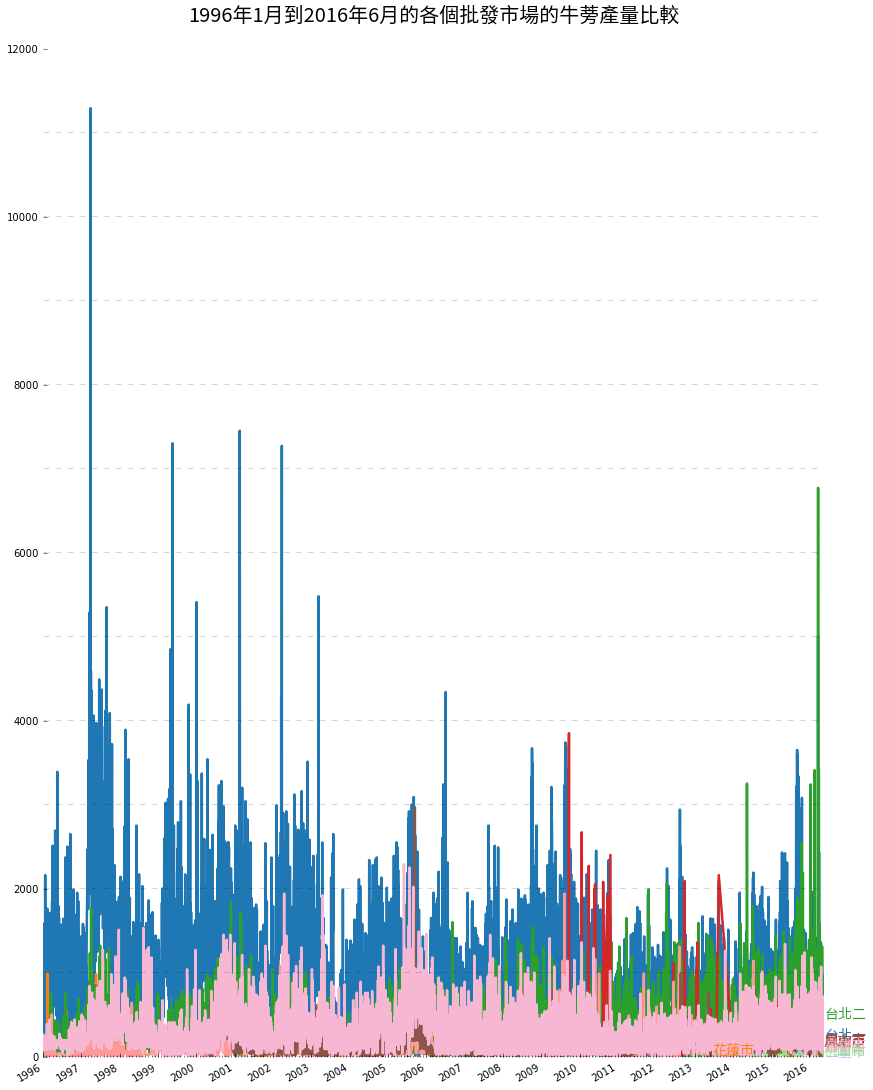

In [46]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

#不同市場的交易狀況－交易量
%matplotlib inline
import os
import numpy
import collections
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
market = {'104':'台北二', '109':'台北一', '241':'三重市', '260':'宜蘭市', '420':'豐原鄉', '512':'永靖鄉', '514':'溪湖鎮', '540':'南投市', '648':'西螺鎮', '900':'屏東市', '400':'台中市', '800':'高雄市', '830':'鳳山市', '338':'桃園縣', '930':'台東市', '950':'花蓮市'}
market_data = market.copy()
for num in market_data.keys():
    market_data[num] = []
majors = market.keys()
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
#字型設定
if os.name == 'posix':#mac電腦的意思
    fpath = r"NotoSansCJKtc-Regular.otf"
else:#windows的電腦用
    fpath = r"NotoSansCJKtc-Regular.otf"
##資料建立
for data in data_list:
    with open(data, 'r') as fout:
        udata = json.load(fout)
    for data in udata:
        if data['crs'] != 'rest':#不載入休市資料
            littletime = datetime.date(int(data['dat'].split('.')[0])+1911, int(data['dat'].split('.')[1]), int(data['dat'].split('.')[2]))
            market_data[data['mas']].append({'dat':littletime, 'pru':data['pru'], 'pro':data['pro'], 'prd':data['prd'], 'prm':data['prm'], 'trv':data['trv']})
for i in market_data.keys():#資料排序
    if len(market_data[i]) > 0:
        market_data[i].sort(key=operator.itemgetter('dat'))#http://stackoverflow.com/questions/2589479/how-do-i-sort-this-list-in-python-if-my-date-is-in-a-string
for i in market_data.keys():#轉變成圖表可以讀取的時間資訊
    if len(market_data[i]) > 0:
        for j in market_data[i]:
            j['dat']=md.date2num(j['dat'])
#找最大值
temp = []
for i in market_data.keys():
    if len(market_data[i]) > 0:
        for j in market_data[i]:
            temp.append(float(j['trv']))
maxdata = int(str(max(temp)).split('.')[0])
##畫出線條
fig, ax = plt.subplots(1, 1, figsize=(14, 20))
for rank, column in enumerate(majors):#開始畫個別的線
    if len(market_data[column]) > 0:
        time_temp = []
        trv_temp = []
        for i in market_data[column]:
            time_temp.append(i['dat'])
            trv_temp.append(i['trv'])
        ax.plot_date(time_temp, trv_temp, '-', lw=2.5, color=color_sequence[rank])
        years = YearLocator()   # every year
        months = MonthLocator()  # every month
        yearsFmt = DateFormatter('%Y')
        #繪製線條旁邊的文字
        x_pos = float(time_temp[-1]) - 0.5
        y_pos = float(trv_temp[-1]) - 0.5
        plt.text(x_pos, y_pos, market[column], fontsize=14, fontproperties=FontProperties(fname=fpath, size=14), color=color_sequence[rank])
plt.title('1996年1月到2016年6月的各個批發市場的牛蒡比較\n', fontproperties=FontProperties(fname=fpath, size=20), ha='center')#繪製圖片的標題#http://matplotlib.org/examples/pylab_examples/fonts_demo.html
#移除一些不必要的東西
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#繪製格線方便使用者看
for y in range(10, maxdata, 1000):
    plt.plot(time_temp, [y] * len(time_temp), '--', lw=0.5, color='black', alpha=0.3)
##繪製圖表
ax.xaxis.set_major_locator(years)#設定大年份
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()
##顯示圖表
fig.autofmt_xdate()
plt.show()
plt.close()


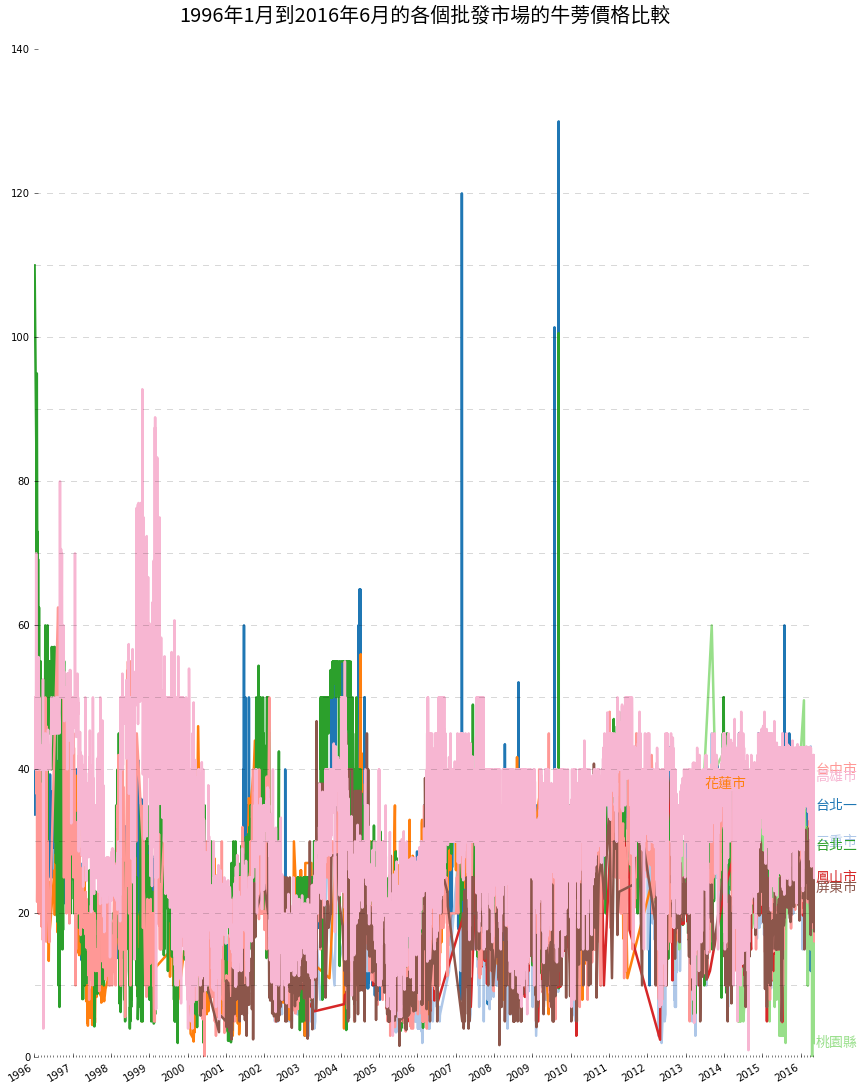

In [47]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

#不同市場的交易狀況－價格
%matplotlib inline
import os
import numpy
import collections
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
market = {'104':'台北二', '109':'台北一', '241':'三重市', '260':'宜蘭市', '420':'豐原鄉', '512':'永靖鄉', '514':'溪湖鎮', '540':'南投市', '648':'西螺鎮', '900':'屏東市', '400':'台中市', '800':'高雄市', '830':'鳳山市', '338':'桃園縣', '930':'台東市', '950':'花蓮市'}
market_data = market.copy()
for num in market_data.keys():
    market_data[num] = []
majors = market.keys()
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
#字型設定
if os.name == 'posix':#mac電腦的意思
    fpath = r"NotoSansCJKtc-Regular.otf"
else:#windows的電腦用
    fpath = r"NotoSansCJKtc-Regular.otf"
##資料建立
for data in data_list:
    with open(data, 'r') as fout:
        udata = json.load(fout)
    for data in udata:
        if data['crs'] != 'rest':#不載入休市資料
            littletime = datetime.date(int(data['dat'].split('.')[0])+1911, int(data['dat'].split('.')[1]), int(data['dat'].split('.')[2]))
            market_data[data['mas']].append({'dat':littletime, 'pru':data['pru'], 'pro':data['pro'], 'prd':data['prd'], 'prm':data['prm'], 'trv':data['trv']})
for i in market_data.keys():#資料排序
    if len(market_data[i]) > 0:
        market_data[i].sort(key=operator.itemgetter('dat'))#http://stackoverflow.com/questions/2589479/how-do-i-sort-this-list-in-python-if-my-date-is-in-a-string
for i in market_data.keys():#轉變成圖表可以讀取的時間資訊
    if len(market_data[i]) > 0:
        for j in market_data[i]:
            j['dat']=md.date2num(j['dat'])
#找最大值
temp = []
for i in market_data.keys():
    if len(market_data[i]) > 0:
        for j in market_data[i]:
            temp.append(float(j['prm']))
maxdata = int(str(max(temp)).split('.')[0])
##畫出線條
fig, ax = plt.subplots(1, 1, figsize=(14, 20))
for rank, column in enumerate(majors):#開始畫個別的線
    if len(market_data[column]) > 0:
        time_temp = []
        prm_temp = []
        for i in market_data[column]:
            time_temp.append(i['dat'])
            prm_temp.append(i['prm'])
        ax.plot_date(time_temp, prm_temp, '-', lw=2.5, color=color_sequence[rank])
        years = YearLocator()   # every year
        months = MonthLocator()  # every month
        yearsFmt = DateFormatter('%Y')
        #繪製線條旁邊的文字
        x_pos = float(time_temp[-1]) - 0.5
        y_pos = float(prm_temp[-1]) - 0.5
        plt.text(x_pos, y_pos, market[column], fontsize=14, fontproperties=FontProperties(fname=fpath, size=14), color=color_sequence[rank])
plt.title('1996年1月到2016年6月的各個批發市場的牛蒡價格比較\n', fontsize=30, fontproperties=FontProperties(fname=fpath, size=20), ha='center')#繪製圖片的標題#http://matplotlib.org/examples/pylab_examples/fonts_demo.html
#移除一些不必要的東西
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#繪製格線方便使用者看
for y in range(10, maxdata, 10):
    plt.plot(time_temp, [y] * len(time_temp), '--', lw=0.5, color='black', alpha=0.3)
##繪製圖表
ax.xaxis.set_major_locator(years)#設定大年份
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()
##顯示圖表
fig.autofmt_xdate()
plt.show()
plt.close()


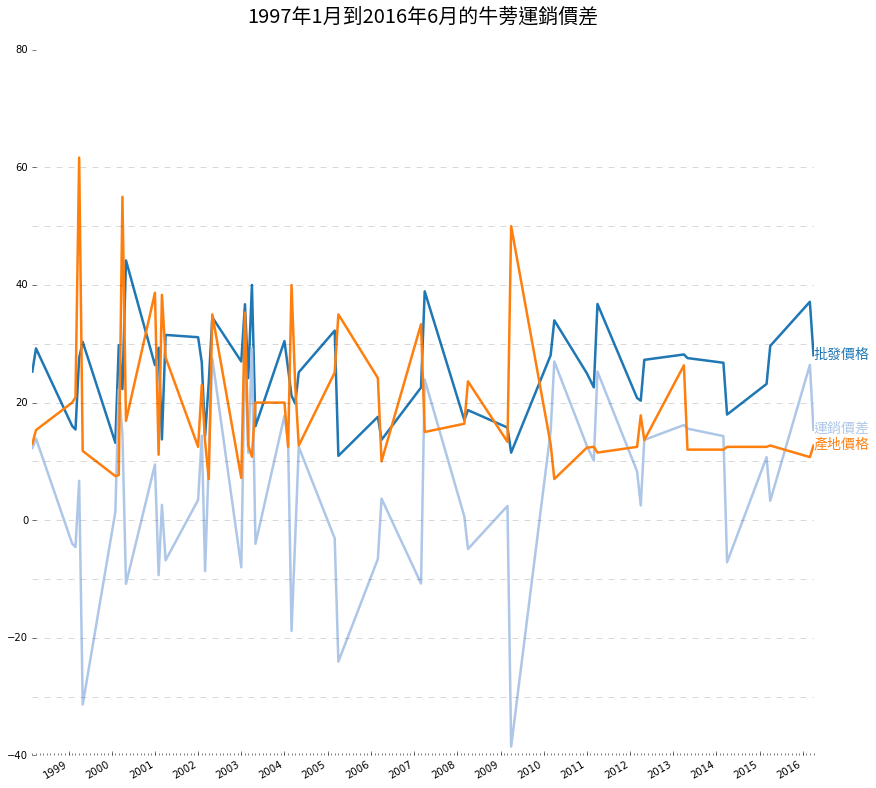

In [156]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

#產地價格與農產品批發市場價格差（運銷價差），算月
#只有收成的季節才會有產地價格
#資料搜集的起始年份和農產品的價格不同，需要從1997年開始看
%matplotlib inline
import os
import csv
import datetime
import collections
from itertools import islice
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
class SortedDisplayDict(dict):#http://stackoverflow.com/questions/9001509/how-can-i-sort-a-dictionary-by-key
   def __str__(self):
       return "{" + ", ".join("%r: %r" % (key, self[key]) for key in sorted(self)) + "}"
#設定資料
newdata = {}
title = ['crs', 'mas', 'dat', 'pru', 'pro', 'prd', 'prm', 'trv']
months = {1:'01', 2:'02', 3:'03', 4:'04', 5:'05', 6:'06', 7:'07', 8:'08', 9:'09', 10:'10', 11:'11', 12:'12'}
url = 'pro_pla_price/month_data.csv'
with open(url, 'r') as fin:
    AQdata = fin.read()
market = {'104':'台北二', '109':'台北一', '241':'三重市', '260':'宜蘭市', '420':'豐原鄉', '512':'永靖鄉', '514':'溪湖鎮', '540':'南投市', '648':'西螺鎮', '900':'屏東市', '400':'台中市', '800':'高雄市', '830':'鳳山市', '338':'桃園縣', '930':'台東市', '950':'花蓮市'}
market_data = market.copy()
for num in market_data.keys():
    market_data[num] = []
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
#字型設定
if os.name == 'posix':#mac電腦的意思
    fpath = r"NotoSansCJKtc-Regular.otf"
else:#windows的電腦用
    fpath = r"NotoSansCJKtc-Regular.otf"
##資料擷取
rowslist = AQdata.split('\n')#把資料換行的時候，當作是切成不同筆資料的分界點，成為多行資料形成的list，一行視為一筆資料
for rows in islice(rowslist, 1, None):#rows = dat,prm，型態為str，而row = [dat,prm]，型態為list
    row = rows.split(',')#要做切開的動作才會變成list
    row[0] = row[0].replace(' ', '')#有空白在當中，會影響辨識，所以要拿掉
    date = row[0].split('.')[0] + '.' +months[int(row[0].split('.')[1])]
    row[1] = row[1].replace(' ', '')#有空白在當中，會影響辨識，所以要拿掉
    if row[1] != 'none':
        newdata[date] = float(row[1])
##資料建立
for data in data_list:
    with open(data, 'r') as fout:
        udata = json.load(fout)
    for data in udata:
        if data['crs'] != 'rest':#不載入休市資料
            littletime = datetime.date(int(data['dat'].split('.')[0])+1911, int(data['dat'].split('.')[1]), int(data['dat'].split('.')[2]))
            market_data[data['mas']].append({'dat':littletime, 'pru':data['pru'], 'pro':data['pro'], 'prd':data['prd'], 'prm':data['prm'], 'trv':data['trv']})
for i in market_data.keys():#資料排序
    if len(market_data[i]) > 0:
        market_data[i].sort(key=operator.itemgetter('dat'))
for i in market_data.keys():
    if len(market_data[i]) > 0:
        for data in market_data[i]:
            data['dat'] = datetime.datetime.strftime(data['dat'], '%Y.%m')

dat_dic = newdata.copy()
for i in dat_dic.keys():
    dat_dic[i] = []
dat_dic = SortedDisplayDict(dat_dic)

for i in market.keys():
    if len(market_data[i]) > 0:#不是空資料者才列印
        for data in market_data[i]:
            newdate = data['dat'].split('.')[0] + data['dat'].split('.')[1]
            if data['dat'] in newdata.keys():
                dat_dic[data['dat']].append(float(data['prm']))
for i in dat_dic.keys():
    dat_dic[i] = sum(float(a) for a in dat_dic[i])/len(dat_dic[i])
#做價差運算：所有批發市場平均價格減去產地價格
delta = newdata.copy()
for i in delta.keys():
    delta[i] = ''
delta = SortedDisplayDict(delta)
for i in dat_dic.keys():
    for j in newdata.keys():
        if i == j:
            delta[i] = dat_dic[i] - newdata[j]
#找最大值
maxdata = int(str(max(newdata.values())).split('.')[0])
mindata = int(str(min(delta.values())).split('.')[0])
bigdata = {'批發價格':dat_dic, '產地價格':newdata, '運銷價差':delta}
##畫出線條
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
for rank, column in enumerate(bigdata.keys()):
    time_temp = []
    pde_temp = []
    for i in bigdata[column].keys():
        time_temp.append(md.date2num(datetime.datetime.strptime(i, '%Y.%m')))
        pde_temp.append(bigdata[column][i])
    time_temp.sort()
    ax.plot_date(time_temp, pde_temp, '-', lw=2.5, color=color_sequence[rank])
    years = YearLocator()   # every year
    months = MonthLocator()  # every month
    yearsFmt = DateFormatter('%Y')
    x_pos = float(time_temp[-1]) - 0.5
    y_pos = float(pde_temp[-1]) - 0.5
    plt.text(x_pos, y_pos, list(bigdata.keys())[rank], fontsize=14, fontproperties=FontProperties(fname=fpath, size=14), color=color_sequence[rank])
plt.title('1997年1月到2016年6月的牛蒡運銷價差\n', fontsize=30, fontproperties=FontProperties(fname=fpath, size=20), ha='center')#繪製圖片的標題#http://matplotlib.org/examples/pylab_examples/fonts_demo.html
#移除一些不必要的東西
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#繪製格線方便使用者看
for y in range(-40, 70, 10):
    plt.plot(time_temp, [y] * len(time_temp), '--', lw=0.5, color='black', alpha=0.3)
##繪製圖表
ax.xaxis.set_major_locator(years)#設定大年份
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()
##顯示圖表
fig.autofmt_xdate()
plt.show()
plt.close()

In [ ]:
# lista = ['a', 'b', 'c', {1:'asd', 2:'ghjkl'}]

# print(lista[0])
# lista[0] = {}
# print(lista[0])
# # a = {}
# # a['xx'] = 'ss'
# # print(a)
# print(dir({}))
# a = 'b'
# c = a
# print(c, a)
# newdataname = {}
# newdataname['new_data'] = {}
# print('new_data')

# print(lista[3][1])
# lista.append([])
# lista[4].append({'ss':'dd'})
# # lista[4][0]['ghjk'] = 'fdfdfdf'
# print(lista)

p = {1:1, 2:2, 4:4, 3:4}
print(p)
p.update({3:5})
print(p)
p.update({5:5})
print(p)
print(len(list(p.items())))
newdataname = {}

# origin = {}
# xx = 0
# for i in range(8):
#     origin.update({1:1})
# for i in range(85, 101):
#     for m in range(1, 13):
#         newdataname[str(i) + str(m)] = []
# print(newdataname)
# newdataname['903'].append(origin)
# print(newdataname)


# newdataname = {}
# for i in range(85, 101):
#     for m in range(1, 13):
#         newdataname[str(i)+str(m)] = {}
# print(newdataname)
# print(len(list(newdataname)))